# CEB102專題-模型預測與分析
2021/05/13 蘇彥庭

In [ ]:
# 載入雲端硬碟
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 安裝相關套件
!pip install shap
!pip install plotly
!pip install xgboost==1.4
!pip install mysql-connector

     |████████████████████████████████| 358kB 7.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=336048f799a778c426bb58d9fb89fc91591fe77f85e4dda5320ec770b99f9529
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 166.7MB 73kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 11.9MB 9.7MB/s 
  Created wheel for mysql-connector: filename=mysql_connector-2.2.9-cp37-cp37m-linux_x86_64.whl size=247949 sha256=6e5c4f368f1abd990de81a5ff63ee2f95f1c8b2997acbd795e570375e0b258a8
  Stored in directory: /root/.cache/pip/wheels/8c/83/a1/f8b6d4bb1bd6208bbde1608bbfa7557504bed9eaf2ecf8c175
Successfully built mysql-connector


In [ ]:
# 從Google API上下載字體放到暫存資料夾底下
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -o NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

--2021-05-21 00:59:26--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M  71.2MB/s    in 1.6s    

2021-05-21 00:59:28 (71.2 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]

Archive:  NotoSansCJKtc-hinted.zip
  inflating: /tmp/fonts/LICENSE_OFL.txt  
  inflating: /tmp/fonts/NotoSansCJKtc-Black.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Bold.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-DemiLight.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Light.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Medium.otf  
  inflating:

In [ ]:
# 載入套件
import os
import json
import pickle
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import shap
import xgboost as xgb

# shap設定
shap.initjs()

# 設定中文字體
font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
  font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"

In [ ]:
# 設定工作目錄
workDir = '/content/drive/MyDrive/CEB102/'
os.chdir(workDir)

In [ ]:
# 建立連線函數
def CreateDBEngine(secretFileName='dbSecret.json'):
    secretFile = json.load(open(secretFileName, 'r'))
    host = secretFile['host']
    username = secretFile['user']
    password = secretFile['password']
    port = secretFile['port']
    database = secretFile['dbName']
    return create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}', echo=False)

# 整理SEGIS模擬資料

In [ ]:
# 查詢SEGIS模擬資料
# 年份為108年, 性別為女生, 婚姻狀況為有偶, 年齡介於18-40之間
sqlQuery = '''
select if(child_cnt>0, 1, 0) as have_child,  # 預測目標: 是否有生小孩
       # person_sn,  # 統號序號
       # household_sn,  # 戶號序號
       # coun_cd,  # 戶籍縣市
       # addr_city_cd,  # 戶籍鄉鎮市區
       if(char_length(addr_village_cd)=11, addr_village_cd, concat('0', addr_village_cd)) as addr_village_cd,  # 戶籍村里
       # gender_cd,  # 性別
       # birthday_date,  # 出生日期
       (year+1911)-year(birthday_date) as age,  # 年紀
       education_cd,  # 教育程度註記
       # marriage_cd,  # 婚姻狀況
       living_type_cd,  # 原住民身分
       # household_type_cd,  # 戶口組織型態_依家庭收支調查
       new_disability_category,  # 身心障礙類別
       low_type_cd,  # 中低收入戶列冊款別
       # first_child_birthday,  # 第一個小孩出生日期
       # child_cnt,  # 出生子女數
       having_house_type_cd  # 有無殼分類
from project.simulation
where year=108 and  # 年份108年
      gender_cd=2 and  # 性別女生 
      marriage_cd=2 and  # 婚姻有偶
      (year+1911)-year(birthday_date) between 18 and 40 and  # 年紀介於18-40之間
      child_cnt is not null and  # 小孩欄位不為null
      education_cd != 6 and  # 教育程度不為null
      having_house_type_cd != '99'  # 有殼不為null
'''

# 取得資料
simulationData = pd.read_sql(sql=sqlQuery, con=CreateDBEngine())

In [ ]:
# 整合中低收入戶列冊款別 將低收入戶與中低收入戶歸為同類並為1 非中低收入戶為0
simulationData['low_type_cd'] = simulationData['low_type_cd'].replace({'L': '1', 'M': '1', 'N': '0'}).astype('int64')

In [ ]:
# 整合有無殼分類狀況 分為有殼為1及無殼為0
simulationData['having_house_type_cd'] = simulationData['having_house_type_cd'].replace({'A': '1', 
                                               'B': '0', 'C1': '1', 'C2': '1', 'D1': '1', 
                                               'D2': '1', 'E': '1', 'F': '1'}).astype('int64')

# 整理SEGIS村里資料

In [ ]:
# 查詢SEGIS村里資料
sqlQuery = '''
select 
county, town, village,
replace(v_id, '-', '') as addr_village_cd,
# convert(COLUMN5, float) as gender_rate,  # 性比例
convert(COLUMN7, float) as population_density,  # 人口密度
# convert(COLUMN74, float) as married_rate,  # 結婚率
# convert(COLUMN75, float) as divorce_rate,  # 離婚率
# convert(COLUMN9, float) as child_dependency_ratio,  # 扶幼比
# convert(COLUMN10, float) as old_age_dependency_ratio,  # 扶老比
convert(COLUMN11, float) as aging_index,  # 老化指數
# convert(COLUMN71, float) as death_rate,  # 死亡率
convert(COLUMN73, float) as social_increase_rate  # 社會增加率
from project.demographic where info_time='108Y'
'''

# 取得資料
segisData = pd.read_sql(sql=sqlQuery, con=CreateDBEngine())

# 整理房價負擔能力統計(縣市)

In [ ]:
# 查詢房價負擔能力統計資料
sqlQuery = '''
select city as county, 
# mbr as house_burden_ratio,  # 房價負擔率(%)
pir as house_price_income_ratio  # 房價所得比(倍)
from project.house_burden_data where season = 4 and year=108
'''

# 取得資料
housingAffordabilityData = pd.read_sql(sql=sqlQuery, con=CreateDBEngine())

# 整理失業率資料

In [ ]:
# 查詢失業率資料
sqlQuery = '''
select area as county, total as unemployment_rate from project.unemployment_rate where year=108;
'''

# 取得資料
unemploymentRateData = pd.read_sql(sql=sqlQuery, con=CreateDBEngine())

# 整理女性勞動力參與率

In [ ]:
# 查詢女性勞動力參與率
sqlQuery = '''
select area as county,
age_15_19_female as female_labor_ratio_15_19,  # 15-19歲女性勞動力參與率(%)
age_20_24_female as female_labor_ratio_20_24,  # 20-24歲女性勞動力參與率(%)
age_25_29_female as female_labor_ratio_25_29,  # 25-29歲女性勞動力參與率(%)
age_30_34_female as female_labor_ratio_30_34,  # 30-34歲女性勞動力參與率(%)
age_35_39_female as female_labor_ratio_35_39,  # 35-39歲女性勞動力參與率(%)
age_40_44_female as female_labor_ratio_40_44   # 40-44歲女性勞動力參與率(%)
from project.labor_force_participation_rate
where year = 108
'''

# 取得資料
laborForceData = pd.read_sql(sql=sqlQuery, con=CreateDBEngine())

# 寬轉長資料
laborForceData = pd.melt(laborForceData, id_vars=['county'], var_name='indicator', value_name='female_labor_ratio')

# 查詢各縣市公幼資訊

In [ ]:
# 查詢各縣市公幼資訊
sqlQuery = '''
select county,
# round(public_school_nums/total_school_nums, 4) as public_kindergarten_ratio,  # 公幼占比
round(public_children/total_children, 4) as public_children_ratio  # 公幼生占比
from project.kindergarten_data
where year=108
'''

# 取得資料
kindergartenData = pd.read_sql(sql=sqlQuery, con=CreateDBEngine())

# 整理托嬰中心資料

In [ ]:
# # 查詢托嬰中心資料
# sqlQuery = '''
# select city as county,
# # 公辦民營托嬰中心占比 = 公辦民營托嬰中心所數/托嬰中心所數
# round(public_to_private_childcare_center/totla_childcare_center, 4) as public_child_care_center_ratio
# from project.number_of_childcare_centers_and_recipients
# where year-1911=108
# '''

# # 取得資料
# childcareCentersData = pd.read_sql(sql=sqlQuery, con=CreateDBEngine())

In [ ]:
# 整理托嬰涵蓋比率(縣市托嬰人數/縣市0-2歲人口數)
sqlQuery = '''
select a.county, round(a.total_babies/b.age_0_2_population, 4) as child_care_cover_ratio
from(
    select year-1911 as year, 
    city as county, total as total_babies
    from project.number_of_childcare_centers_and_recipients
) as a
left join (
    select
    convert(replace(info_time, 'Y', ''), unsigned) as year,  # 年度
    COUNTY as county,  # 縣市名稱
    sum(COLUMN108+COLUMN109+COLUMN110) as age_0_2_population  # 0-2歲學齡人口數
    from project.demographic
    group by info_time, county
) as b
on a.year=b.year and a.county=b.county
where a.year=108
'''

# 取得資料
childCareCoverRatio = pd.read_sql(sql=sqlQuery, con=CreateDBEngine())

# 整合特徵資料

In [ ]:
# 讀取模擬資料做為特徵資料主表
featureData = simulationData

In [ ]:
# 併入SEGIS資料集
featureData = pd.merge(featureData, segisData, on='addr_village_cd')
# 併入房價負擔能力資料集
featureData = pd.merge(featureData, housingAffordabilityData, on='county')
# 併入失業率資料
featureData = pd.merge(featureData, unemploymentRateData, on='county')
# 併入各縣市公幼資訊
featureData = pd.merge(featureData, kindergartenData, on='county')
# # 併入托嬰中心資料
# featureData = pd.merge(featureData, childcareCentersData, on='county')
# 併入托嬰涵蓋比率資料
featureData = pd.merge(featureData, childCareCoverRatio, on='county')

In [ ]:
# 併入勞動參與率
# 建立指標對應年紀清單
correspondingData = pd.DataFrame({'indicator': ['female_labor_ratio_15_19', 'female_labor_ratio_20_24', 'female_labor_ratio_25_29', 
                            'female_labor_ratio_30_34', 'female_labor_ratio_35_39', 'female_labor_ratio_40_44'],
                            'age': [list(range(15, 20)), list(range(20, 25)), list(range(25, 30)), list(range(30, 35)),
                                    list(range(35, 40)), list(range(40, 45))]}).explode('age')

# 依據年紀併入對應指標名稱
featureData = pd.merge(featureData, correspondingData, on='age')
# 併入勞動參與率資料
featureData = pd.merge(featureData, laborForceData, on=['county', 'indicator'])
# 刪除過渡變數
featureData = featureData.drop(['indicator'], axis=1)

In [ ]:
# 整理WEB所需的女性勞動參與率資料
laborForceData = pd.merge(laborForceData, correspondingData, how='outer', on=['indicator'])[['county', 'female_labor_ratio',	'age']]

In [ ]:
# 檢查缺值資料
featureData[featureData.isnull().any(axis=1)]

,have_child,addr_village_cd,age,education_cd,living_type_cd,new_disability_category,low_type_cd,having_house_type_cd,county,town,village,population_density,aging_index,social_increase_rate,house_price_income_ratio,unemployment_rate,public_children_ratio,child_care_cover_ratio,female_labor_ratio
94250,1,10002110007,40,1,1,0,0,1,宜蘭縣,大同鄉,太平村,0.32,900.0,NaN,7.5,3.7,0.4964,0.0364,74.1


In [ ]:
# 刪除缺值資料
featureData = featureData.dropna()

In [ ]:
# 檢查資料內容
featureData.info()
featureData.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103558 entries, 0 to 103558
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   have_child                103558 non-null  int64  
 1   addr_village_cd           103558 non-null  object 
 2   age                       103558 non-null  object 
 3   education_cd              103558 non-null  int64  
 4   living_type_cd            103558 non-null  int64  
 5   new_disability_category   103558 non-null  int64  
 6   low_type_cd               103558 non-null  int64  
 7   having_house_type_cd      103558 non-null  int64  
 8   county                    103558 non-null  object 
 9   town                      103558 non-null  object 
 10  village                   103558 non-null  object 
 11  population_density        103558 non-null  float64
 12  aging_index               103558 non-null  float64
 13  social_increase_rate      103558 non-null  f

,have_child,addr_village_cd,age,education_cd,living_type_cd,new_disability_category,low_type_cd,having_house_type_cd,county,town,village,population_density,aging_index,social_increase_rate,house_price_income_ratio,unemployment_rate,public_children_ratio,child_care_cover_ratio,female_labor_ratio
72469,1,68000100012,25,3,0,0,0,1,桃園市,平鎮區,平鎮里,3525.65,114.95,-12.28,7.26,3.8,0.2128,0.0403,93.6
35264,0,68000100011,37,4,0,0,0,1,桃園市,平鎮區,北貴里,14797.60,84.38,-2.03,7.26,3.8,0.2128,0.0403,75.2
72137,1,68000010055,25,4,0,0,0,1,桃園市,桃園區,中德里,3284.28,65.48,-14.80,7.26,3.8,0.2128,0.0403,93.6
64307,0,65000050067,26,4,0,0,0,1,新北市,新莊區,龍安里,27934.30,112.79,-26.36,11.72,3.8,0.3087,0.0907,92.4
32373,1,68000080008,38,1,0,0,0,0,桃園市,八德區,廣隆里,11316.00,86.86,4.58,7.26,3.8,0.2128,0.0403,75.2
78148,1,10015010002,30,3,0,0,0,1,花蓮縣,花蓮市,民運里,6038.53,254.02,14.78,7.88,3.6,0.5276,0.0161,91.3
63894,1,64000170010,29,2,0,0,0,1,高雄市,仁武區,高楠里,1303.28,188.84,159.80,7.11,3.7,0.2078,0.0357,90.6
89014,1,66000280001,31,2,0,0,0,0,臺中市,大里區,大里里,3343.94,113.36,16.99,9.80,3.7,0.2037,0.0601,84.2
25572,0,66000070021,35,2,0,0,0,0,臺中市,南屯區,大業里,27519.40,64.17,11.46,9.80,3.7,0.2037,0.0601,77.1
27786,1,66000170003,37,3,0,0,0,1,臺中市,潭子區,潭北里,10927.30,114.71,4.67,9.80,3.7,0.2037,0.0601,77.1


In [ ]:
# 儲存資料
featureData.to_csv('featureData.csv', index=False, encoding='utf-8-sig')

# 機器學習前置作業

In [ ]:
# 讀取資料
featureData = pd.read_csv('featureData.csv')
featureData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103558 entries, 0 to 103557
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   have_child                103558 non-null  int64  
 1   addr_village_cd           103558 non-null  int64  
 2   age                       103558 non-null  int64  
 3   education_cd              103558 non-null  int64  
 4   living_type_cd            103558 non-null  int64  
 5   new_disability_category   103558 non-null  int64  
 6   low_type_cd               103558 non-null  int64  
 7   having_house_type_cd      103558 non-null  int64  
 8   county                    103558 non-null  object 
 9   town                      103558 non-null  object 
 10  village                   103558 non-null  object 
 11  population_density        103558 non-null  float64
 12  aging_index               103558 non-null  float64
 13  social_increase_rate      103558 non-null  f

In [ ]:
# 設立預測目標
featureData.insert(0, 'predictY', featureData['have_child'])
featureData = featureData.drop(['have_child'], axis=1)

In [ ]:
# 建立預測目標與特徵資料集
X = featureData.drop(['predictY', 'addr_village_cd', 'county', 'town', 'village'], axis=1)
y = featureData['predictY']

In [ ]:
# 分層抽樣: 以里為單位手動分割訓練集與測試集
villageCodeList = featureData['addr_village_cd'].drop_duplicates().tolist()
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series(dtype='int64', name='predictY')
y_test = pd.Series(dtype='int64', name='predictY')
for villageCode in villageCodeList:
    matchSite = featureData['addr_village_cd'] == villageCode
    if len(X[matchSite]) > 1:
        iX_train, iX_test, iy_train, iy_test = train_test_split(X[matchSite], y[matchSite], test_size=0.2, random_state=666)
        X_train = pd.concat([X_train, iX_train])
        X_test = pd.concat([X_test, iX_test])
        y_train = pd.concat([y_train, iy_train])
        y_test = pd.concat([y_test, iy_test])

# 重設index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
# 檢查樣本分布
print('訓練集樣本數:', len(y_train))
print(y_train.value_counts().to_frame('樣本數比率'))
print(y_train.value_counts(normalize=True).to_frame('樣本數比率'))
print('測試集樣本數:', len(y_test))
print(y_test.value_counts().to_frame('樣本數比率'))
print(y_test.value_counts(normalize=True).to_frame('樣本數比率'))

In [ ]:
# 計算XGBoost調整不平衡資料集樣本權重
# 公式: sum(negative instances) / sum(positive instances)
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
scale_pos_weight

In [ ]:
# 建立特徵中文名稱
chColumnNames = {'age': '年紀',
                 'education_cd': '教育程度',
                 'living_type_cd': '原住民身分',
                 'new_disability_category': '身心障礙',
                 'low_type_cd': '中低收入戶',
                 'having_house_type_cd': '是否有殼',
                 'gender_rate': '性比例', 
                 'population_density': '人口密度',
                 'married_rate': '結婚率', 
                 'divorce_rate': '離婚率',
                 'child_dependency_ratio': '扶幼比', 
                 'old_age_dependency_ratio': '扶老比', 
                 'aging_index': '老化指數',
                 'death_rate': '死亡率', 
                 'social_increase_rate': '社會增加率',
                 'house_burden_ratio': '房價負擔率',
                 'house_price_income_ratio': '房價所得比',
                 'unemployment_rate': '失業率',
                 'public_kindergarten_ratio': '公幼家數比',
                 'public_children_ratio': '公幼生佔比',
                 'public_child_care_center_ratio': '公辦民營托嬰中心占比',
                 'child_care_cover_ratio': '托嬰比率',
                 'female_labor_ratio': '女性勞動參與率'
                 }

featureChName = [chColumnNames[elem] for elem in X_train.columns]

In [ ]:
# 計算訓練集相關係數矩陣
trainCorrMatrix = pd.concat([X_train, y_train], axis=1)
columnNames = featureChName.copy()
columnNames.append('預測目標Y')
trainCorrMatrix.columns = columnNames
trainCorrMatrix = trainCorrMatrix.corr()
trainCorrMatrix.style.background_gradient(cmap='coolwarm').set_precision(2)


,年紀,教育程度,原住民身分,身心障礙,中低收入戶,是否有殼,人口密度,老化指數,社會增加率,房價所得比,失業率,公幼生佔比,托嬰比率,女性勞動參與率,預測目標Y
年紀,1.00,-0.08,-0.00,0.02,0.01,-0.00,0.00,0.01,0.00,-0.01,0.00,0.01,0.00,0.37,0.04
教育程度,-0.08,1.00,-0.08,-0.07,-0.04,0.14,0.10,-0.04,-0.00,0.14,-0.00,-0.01,0.10,0.03,-0.14
原住民身分,-0.00,-0.08,1.00,0.01,0.03,-0.07,-0.05,-0.01,-0.01,-0.05,-0.03,0.09,-0.06,-0.01,0.03
身心障礙,0.02,-0.07,0.01,1.00,0.01,-0.02,-0.02,0.02,-0.00,-0.01,-0.01,0.01,-0.02,-0.00,-0.00
中低收入戶,0.01,-0.04,0.03,0.01,1.00,-0.04,-0.02,0.02,-0.02,-0.02,-0.03,0.01,-0.04,0.00,0.02
是否有殼,-0.00,0.14,-0.07,-0.02,-0.04,1.00,0.04,-0.06,0.03,0.01,0.08,-0.06,0.05,-0.02,-0.04
人口密度,0.00,0.10,-0.05,-0.02,-0.02,0.04,1.00,-0.11,-0.07,0.48,0.29,0.09,0.43,0.04,-0.05
老化指數,0.01,-0.04,-0.01,0.02,0.02,-0.06,-0.11,1.00,-0.21,-0.08,-0.15,0.22,-0.17,0.04,-0.01
社會增加率,0.00,-0.00,-0.01,-0.00,-0.02,0.03,-0.07,-0.21,1.00,-0.11,0.13,-0.11,0.01,-0.02,0.00
房價所得比,-0.01,0.14,-0.05,-0.01,-0.02,0.01,0.48,-0.08,-0.11,1.00,0.16,0.25,0.69,0.09,-0.06


In [ ]:
# # 繪製t期各變數與t+1期相關係數值
# fig = px.bar(trainCorrMatrix['predictY'])
# fig.update_layout(title={'text': 't+1期出生率與t期特徵之相關係數', 'x': 0.5},
#                   showlegend=False,
#                   xaxis_title="特徵名稱",
#                   yaxis_title="相關係數")
# fig.show()

In [ ]:
# 檢驗共線性
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
vif_data[vif_data["VIF"]>10]

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


,feature,VIF
0,age,31.662415
9,house_price_income_ratio,34.639126
10,unemployment_rate,75.897976
11,public_children_ratio,14.957543
12,child_care_cover_ratio,12.809800
13,female_labor_ratio,49.625731


# XGBoost模型(預測分類)

In [ ]:
# 建立XGBoost Data Matrix
trainDMatrix = xgb.DMatrix(data=X_train, label=y_train, feature_names=featureChName)
testDMatrix = xgb.DMatrix(data=X_test, label=y_test, feature_names=featureChName)

In [ ]:
from sklearn.model_selection import ParameterGrid

# 設定參數組合
paramGrid = {
    'objective':['binary:logistic'],
    'scale_pos_weight': [scale_pos_weight],  # 調整不平衡資料集樣本權重
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5, 6, 7],
    'colsample_bytree': [0.7, 0.9],
    'subsample': [0.7, 0.9],
    'tree_method': ['gpu_hist']
}
paramGrid = list(ParameterGrid(paramGrid))

In [ ]:
# 迴圈計算最佳參數組合
cvTestEval = list()
cvTestRounds = list()
for params in paramGrid:
    
    # 執行交叉驗證
    cv_results = xgb.cv(params=params,
                        dtrain=trainDMatrix,
                        num_boost_round=10000,
                        nfold=5,
                        # metrics="auc",
                        metrics="logloss",
                        early_stopping_rounds=50)
    
    
    # 紀錄交叉驗證平均誤差
    # cvTestEval.append(float(cv_results['test-auc-mean'].tail(1)))
    cvTestEval.append(float(cv_results['test-logloss-mean'].tail(1)))
    
    # 紀錄XGBoost最適疊代次數
    cvTestRounds.append(len(cv_results))

In [ ]:
print(cvTestEval)
print(cvTestRounds)

[0.6670005999999999, 0.6665220000000001, 0.6635665999999999, 0.6613206, 0.6589124, 0.654738, 0.6529728, 0.6489621999999999, 0.647297, 0.644613, 0.6665772000000001, 0.6650708, 0.6617662, 0.6603832000000001, 0.658056, 0.6557179999999999, 0.6539318, 0.6517068, 0.650603, 0.6476254, 0.6669362000000001, 0.6657303999999999, 0.6632546, 0.6616458, 0.6584692, 0.6547498, 0.6532568, 0.6480988, 0.6473842, 0.6432408, 0.6662452, 0.6651538, 0.6617398, 0.6601096, 0.6583003999999999, 0.6552088, 0.6544487999999999, 0.650746, 0.6501756000000001, 0.6475134]
[1122, 1681, 2078, 4135, 2571, 6044, 3105, 5681, 3024, 4182, 164, 445, 516, 741, 517, 906, 516, 712, 332, 445, 1120, 2568, 2078, 3591, 2572, 5393, 2572, 5945, 2582, 4827, 164, 362, 517, 637, 444, 811, 443, 742, 333, 436]


In [ ]:
# 取test-logloss-mean最小值的參數組合
bestParamsIdx = cvTestEval.index(min(cvTestEval))
bestParams = paramGrid[bestParamsIdx]
bestRounds = cvTestRounds[bestParamsIdx]
print('XGBoost最佳參數組合:', bestParams)
print('XGBoost最佳疊代數:', bestRounds)

XGBoost最佳參數組合: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'objective': 'binary:logistic', 'scale_pos_weight': 0.28855986193771066, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
XGBoost最佳疊代數: 4827


In [ ]:
# 以最佳參數組合訓練模型
xgbModel = xgb.train(params=bestParams, dtrain=trainDMatrix, num_boost_round=bestRounds)

[01:20:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
# 儲存模型
xgbModel.save_model("xgboost_model.txt")

In [ ]:
# 模型預測
xgboost_train_pred = xgbModel.predict(trainDMatrix)
xgboost_test_pred = xgbModel.predict(testDMatrix)

# y_train_pred = np.where(xgboost_train_pred > 0.5, 1, 0)
# y_test_pred = np.where(xgboost_test_pred > 0.5, 1, 0)
# print('最佳參數組合XGBoost模型預測train的accuracy:', accuracy_score(y_train, y_train_pred))
# print('最佳參數組合XGBoost模型預測test的accuracy:', accuracy_score(y_test, y_test_pred))

In [ ]:
# 建立Dash所需的範例特徵集
villageFeatureInfo = featureData[['county', 'town', 'village', 'population_density', 'aging_index', 
                                  'social_increase_rate', 'house_price_income_ratio', 'unemployment_rate', 
                                  'public_children_ratio', 'child_care_cover_ratio']].drop_duplicates().reset_index(drop=True)

In [ ]:
# 績效指標函數
def performance_eval(y_true, y_score, cutoff=0.5):
    """Performance Evaluate
    Args:
        y_true: samples true class
        y_score: model predict class score
        cutoff: model predict class threshold
    Returns:
        pandas dataframe: performance evaluate table 
    """
    
    # 模型依據cutoff值預測結果
    y_pred = np.where(y_score > cutoff, 1, 0)

    return pd.DataFrame({'metric': ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                         'score': [round(accuracy_score(y_true, y_pred), 4), 
                                   round(precision_score(y_true, y_pred), 4),
                                   round(recall_score(y_true, y_pred), 4), 
                                   round(f1_score(y_true, y_pred), 4), 
                                   round(roc_auc_score(y_true, y_score), 4)]})

In [ ]:
# 訓練集資料指標函數
performanceEvalData = pd.merge(performance_eval(y_true=y_train, y_score=xgboost_train_pred, cutoff=0.5),
                               performance_eval(y_true=y_test, y_score=xgboost_test_pred, cutoff=0.5),
                               on=['metric'])
performanceEvalData.columns = ['指標', '訓練集分數', '測試集分數']
performanceEvalData

,指標,訓練集分數,測試集分數
0,accuracy,0.7417,0.6396
1,precision,0.9316,0.8300
2,recall,0.7200,0.6825
3,f1,0.8123,0.7491
4,roc_auc,0.8541,0.6200


In [ ]:
def plotly_confusion_matrix(y_true, y_score, cutoff=0.5, labels = None, percentage=True):
    """Generates Plotly fig confusion matrix
    Args:
        cm (np.ndarray): generated by sklearn.metrics.confusion_matrix(y_true, preds)
        labels (List[str], optional): List of labels for classes. Defaults to None.
        percentage (bool, optional): Display percentages instead of absolute number. 
            Defaults to True.
    Returns:
        Plotly fig
    """

    # 計算confusion matrix
    y_pred = np.where(y_score > cutoff, 1, 0)
    cm = confusion_matrix(y_true, y_pred)

    cm_normalized = np.round(100*cm / cm.sum(), 1)

    if labels is None:
        labels = [str(i) for i in range(cm.shape[0])] 

    zmax = cm.sum()
        
    data=[go.Heatmap(
        z=cm,
        x=[f" {lab}" for lab in labels],
        y=[f" {lab}" for lab in labels],
        hoverinfo="skip",
        zmin=0, zmax=zmax, colorscale='Blues',
        showscale=False,
    )]
    
    layout = go.Layout(
            title="混淆矩陣(Confusion Matrix)",
            xaxis=dict(title='預測分類',
                       constrain="domain",
                       tickmode = 'array',
                       tickvals = [f" {lab}" for lab in labels],
                       ticktext = [f" {lab}" for lab in labels]),
            yaxis=dict(title=dict(text='實際分類',standoff=20),
                       autorange="reversed", 
                       side='left',
                       scaleanchor='x', 
                       scaleratio=1,
                       tickmode = 'array',
                       tickvals = [f" {lab}" for lab in labels],
                       ticktext = [f" {lab}" for lab in labels]),
            plot_bgcolor = '#fff',
        )
    fig = go.Figure(data, layout)
    annotations = []
    for x in range(cm.shape[0]):
        for y in range(cm.shape[1]):
            top_text = f"{cm_normalized[x, y]}%" if percentage else f"{cm[x, y]}"
            bottom_text = f"{cm_normalized[x, y]}%" if not percentage else f"{cm[x, y]}" 
            annotations.extend([
                go.layout.Annotation(
                    x=fig.data[0].x[y], 
                    y=fig.data[0].y[x], 
                    text=top_text, 
                    showarrow=False,
                    font=dict(size=20)
                ),
                go.layout.Annotation(
                    x=fig.data[0].x[y], 
                    y=fig.data[0].y[x], 
                    text=f" <br> <br> <br>({bottom_text})", 
                    showarrow=False,
                    font=dict(size=12)
                )]
            )
                
    fig.update_layout(annotations=annotations)
    return fig

In [ ]:
# 訓練集混淆矩陣
plotly_confusion_matrix(y_true=y_train, y_score=xgboost_train_pred, cutoff=0.5, labels = ['沒小孩', '有小孩'], percentage=True)

In [ ]:
# 測試集混淆矩陣
plotly_confusion_matrix(y_true=y_test, y_score=xgboost_test_pred, cutoff=0.5, labels = ['沒小孩', '有小孩'], percentage=True)

In [ ]:
# 繪製ROC-AUC圖形
def plotly_roc_auc_curve(fpr, tpr, thresholds, score, cutoff=None, round=2):
    """Plot ROC AUC curve
    Args:
        fpr
        tpr
        thresholds
        cutoff (float, optional): Cutoff proba to display. Defaults to None.
        round (int, optional): rounding of floats. Defaults to 2.
    Returns:
        Plotly Fig: 
    """
    
    trace0 = go.Scatter(x=fpr, y=tpr,
                    mode='lines',
                    name='ROC AUC CURVE',
                    text=[f"threshold: {th:.{round}f} <br> FP: {fp:.{round}f} <br> TP: {tp:.{round}f}" 
                              for fp, tp, th in zip(fpr, tpr, thresholds)],
                    hoverinfo="text"
                )
    data = [trace0]
    layout = go.Layout(title='ROC曲線', 
                    #    width=450,
                    #    height=450,
                       xaxis= dict(title='False Positive Rate', range=[0,1], constrain="domain"),
                       yaxis = dict(title='True Positive Rate', range=[0,1], constrain="domain", 
                                    scaleanchor='x', scaleratio=1),
                       hovermode='closest',
                       plot_bgcolor = '#fff',)
    fig = go.Figure(data, layout)
    shapes = [dict(type='line',
                   xref='x',
                   yref='y',
                   x0=0,
                   x1=1,
                   y0=0,
                   y1=1,
                   line=dict(color="darkslategray", width=4, dash="dot"),
                   )]
    
    if cutoff is not None:
        threshold_idx = np.argmin(np.abs(thresholds-cutoff))
        cutoff_tpr = tpr[threshold_idx]
        cutoff_fpr = fpr[threshold_idx]

        shapes.append(
            dict(type='line', xref='x', yref='y',
                x0=0, x1=1, y0=cutoff_tpr, y1=cutoff_tpr,
                line=dict(color="lightslategray",width=1)))
        shapes.append(
            dict(type='line', xref='x', yref='y',
                 x0=cutoff_fpr, x1=cutoff_fpr, y0=0, y1=1,
                 line=dict(color="lightslategray", width=1)))
        
        annotations = [go.layout.Annotation(x=0.6, y=0.4, 
                            text=f"roc-auc-score: {score:.{round}f}",
                            showarrow=False, align="right", 
                            xanchor='left', yanchor='top'),
                       go.layout.Annotation(x=0.6, y=0.35, 
                            text=f"cutoff: {cutoff:.{round}f}",
                            showarrow=False, align="right", 
                            xanchor='left', yanchor='top'),
                       go.layout.Annotation(x=0.6, y=0.3, 
                            text=f"TPR: {cutoff_tpr:.{round}f}",
                            showarrow=False, align="right", 
                            xanchor='left', yanchor='top'),
                       go.layout.Annotation(x=0.6, y=0.24, 
                            text=f"FPR: {cutoff_fpr:.{round}f}",
                            showarrow=False, align="right", 
                            xanchor='left', yanchor='top'),
                       ]
        fig.update_layout(annotations=annotations)
                                            
    fig.update_layout(shapes=shapes)
    return fig

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true=y_train, y_score=xgboost_train_pred, pos_label=1)
plotly_roc_auc_curve(fpr=fpr, tpr=tpr, thresholds=thresholds, score=xgboost_train_pred, cutoff=None, round=2)

In [ ]:
# # 繪製變數重要程度
# xgb.plot_importance(xgbModel, importance_type='gain')

In [ ]:
# 進行SHAP分析
explainer = shap.TreeExplainer(xgbModel)
train_shap_values = explainer(X_train)

In [ ]:
# 計算SHAP重要程度
shapValueDf = pd.DataFrame(train_shap_values.values, columns=featureChName)
shapImportanceDf = shapValueDf.apply(lambda x: round(np.mean(np.abs(x)), 4)).sort_values(ascending=True)
shapImportanceDf

身心障礙       0.0014
中低收入戶      0.0056
原住民身分      0.0057
失業率        0.0084
女性勞動參與率    0.0217
公幼生佔比      0.0257
托嬰比率       0.0351
社會增加率      0.0422
是否有殼       0.0476
房價所得比      0.0514
人口密度       0.0534
老化指數       0.0542
年紀         0.0793
教育程度       0.2827
dtype: float64

In [ ]:
# 繪製重要程度圖形
feature_names = shapImportanceDf.index.tolist()
importance_values = shapImportanceDf.tolist()
data = [go.Bar(y=feature_names,
               x=importance_values,
               orientation='h')]
layout = go.Layout(
    title='特徵重要程度(Mean absolute SHAP value)',
    plot_bgcolor = '#fff',
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)
fig.update_layout(height=200+len(feature_names)*20,
                  margin=go.layout.Margin(l=100, r=50, b=50, t=50, pad=4))
fig.show()

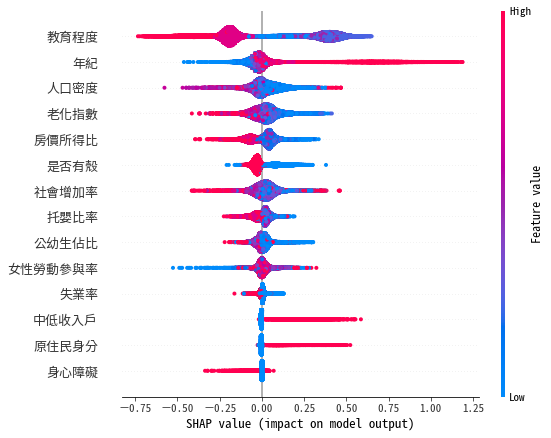

In [ ]:
# 繪製SHAP value
shap.summary_plot(train_shap_values, X_train, feature_names=featureChName)

In [ ]:
# 傳入樣本分析
age = 26
education_cd = 2
living_type_cd = 0
new_disability_category = 0
low_type_cd = 0
having_house_type_cd = 1
population_density = 10815
aging_index = 168.33
social_increase_rate = 2.96
house_price_income_ratio = 7.5
unemployment_rate = 3.7
public_children_ratio = 0.4964
child_care_cover_ratio = 0.0364
female_labor_ratio = 96.2
singleSample = pd.DataFrame(np.array([[age, education_cd, living_type_cd, new_disability_category, low_type_cd, 
                                       having_house_type_cd, population_density, aging_index, social_increase_rate, 
                                       house_price_income_ratio, unemployment_rate, public_children_ratio, child_care_cover_ratio, 
                                       female_labor_ratio]]), columns=featureChName)
singleSampleDMatrix = xgb.DMatrix(data=singleSample, feature_names=featureChName)

# 模型預測
singleSamplePredict = xgbModel.predict(singleSampleDMatrix)

# SHAP分析
single_shap_values = explainer(singleSampleDMatrix)

In [ ]:
# 定義sigmoid函數
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# 建立特徵貢獻表
featureAddProb = sigmoid(single_shap_values.values[0]+single_shap_values.base_values)-sigmoid(single_shap_values.base_values)
contributionDf = pd.DataFrame({'feature': featureChName, 
                               'addProb': featureAddProb,
                               'measure': 'relative'})
contributionDf = contributionDf.sort_values('addProb', ascending=False)

# 加入全樣本平均值資訊
contributionDf = pd.concat([pd.DataFrame({'feature': '全樣本平均值', 'addProb': sigmoid(single_shap_values.base_values), 'measure': 'absolute'}), contributionDf])

# 加入最後預測資訊資訊
contributionDf = pd.concat([contributionDf, pd.DataFrame({'feature': '最終預測結果', 'addProb': singleSamplePredict, 'measure': 'total'})])
contributionDf = contributionDf.reset_index(drop=True)
contributionDf['addProb'] = round(contributionDf['addProb']*100, 2)
contributionDf

,feature,addProb,measure
0,全樣本平均值,49.630001,absolute
1,教育程度,9.400000,relative
2,房價所得比,1.300000,relative
3,托嬰比率,1.100000,relative
4,女性勞動參與率,0.570000,relative
5,失業率,0.240000,relative
6,原住民身分,0.030000,relative
7,身心障礙,0.010000,relative
8,老化指數,-0.030000,relative
9,中低收入戶,-0.040000,relative


In [ ]:
fig = go.Figure(go.Waterfall(
    x = contributionDf["feature"],
    measure = contributionDf["measure"],
    y = contributionDf["addProb"], base = 0,
    decreasing = {"marker":{"color": "rgba(50, 200, 50, 1.0)"}},
    increasing = {"marker":{"color": "rgba(219, 64, 82, 0.7)"}},
    totals = {"marker":{"color": "rgba(230, 230, 30, 1.0)"}}
))

fig.update_layout(title = f"特徵貢獻預測機率瀑布圖 預測機率={round(singleSamplePredict[0]*100, 2)}%", 
                  xaxis=dict(title="特徵名稱"),
                  yaxis=dict(title="預測機率(%)"),
                  waterfallgap = 0.3)
fig.show()

In [ ]:
# 儲存WEB所需資料
with open('web_ml_model_data.pkl', 'wb') as f:
    pickle.dump([y_train, y_test, xgboost_train_pred, xgboost_test_pred, shapImportanceDf, villageFeatureInfo, laborForceData, featureChName], f)

In [ ]:
# 測試讀取資料
with open('web_ml_model_data.pkl', 'rb') as f:
    y_train, y_test, xgboost_train_pred, xgboost_test_pred, shapImportanceDf, villageFeatureInfo, laborForceData, featureChName = pickle.load(f)

In [ ]:
# 讀取模型
xgbModel = xgb.Booster()
xgbModel.load_model("xgboost_model.txt")

In [ ]:
# 進行SHAP分析
explainer = shap.TreeExplainer(xgbModel)

In [ ]:
# 繪製特定區域樣本的SHAP分析
explainer = shap.TreeExplainer(xgbModel)
for targetCounty in featureData['county'].drop_duplicates().tolist():
    for targetTown in featureData['town'].drop_duplicates().tolist():
        X_analysis = X[(featureData['county']==targetCounty) & (featureData['town']==targetTown)]
        if len(X_analysis) > 0:
            shap_values = explainer(X_analysis)
            shap.summary_plot(shap_values, X_analysis, feature_names=featureChName, show=False)
            plt.savefig(f'town_shap_fig/{targetCounty}_{targetTown}.png', bbox_inches='tight')
            plt.clf()

<Figure size 576x511.2 with 0 Axes>

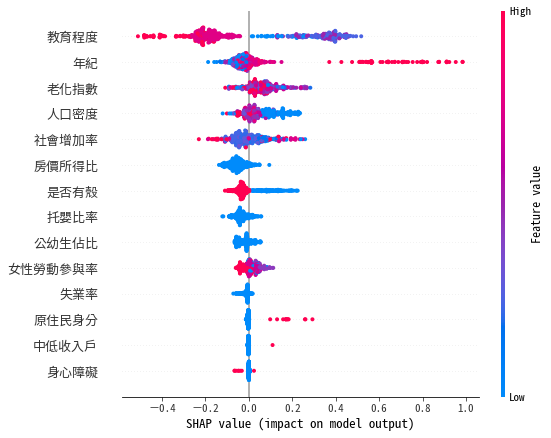

In [ ]:
# # 繪製特定區域樣本
# targetCounty = '新北市'
# targetTown = '林口區'
# X_analysis = X[(featureData['county']==targetCounty) & (featureData['town']==targetTown)]
# shap_values = explainer(X_analysis)
# shap.summary_plot(shap_values, X_analysis, feature_names=featureChName, show=False)
# plt.savefig(f'town_shap_fig/{targetCounty}_{targetTown}.png', bbox_inches='tight')